In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gstools as gs
from mpl_toolkits.mplot3d import Axes3D
# Initialize W&B
#import wandb

ModuleNotFoundError: No module named 'wandb'

# Generate 100,000 GRFs

In [38]:
grfs = []
x = y = range(64)
model = gs.Gaussian(dim=2, var=1, len_scale=10)
srf = gs.SRF(model)

# Generate GRFs
for i in range(1000000):
    grf = srf((x, y), mesh_type='structured', seed=i)
    grfs.append(grf)

# Apply truncation: values <= 0 set to 0, values > 0 set to 1
tgrfs = []
for grf in grfs:
    tgrf = (grf > 0).astype(int)  # Convert condition to 0 (false) and 1 (true)
    tgrfs.append(tgrf)

# Convert to numpy arrays
grfs = np.array(grfs)
tgrfs = np.array(tgrfs)

# Plot GRFs and TGRFs in a grid
fig, axs = plt.subplots(2, 5)
for i, ax in enumerate(axs.flat):
    ax.imshow(grfs[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'GRF {i+1}')
plt.suptitle('GRFs')
plt.show()
fig, axs = plt.subplots(2, 5)
for i, ax in enumerate(axs.flat):
    ax.imshow(tgrfs[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'TGRF {i+1}')
plt.suptitle('TGRFs')
plt.show()

In [31]:
# Define the embedding matrix (16 embeddings of dimension 4)
embedding_matrix = torch.zeros((16, 4))

# Generate all possible 2x2 binary patches
patches = torch.tensor([
    [a, b, c, d]
    for a in range(2)
    for b in range(2)
    for c in range(2)
    for d in range(2)
])

# Calculate the embeddings
for i, patch in enumerate(patches):
    total_ones = patch.sum().item()
    if total_ones == 0:
        # Avoid division by zero, leave as zeros (or handle as needed)
        continue
    # Define the positions in the patch
    left_column = patch[::2].sum().item()
    right_column = patch[1::2].sum().item()
    lower_row = patch[2:].sum().item()
    upper_row = patch[:2].sum().item()
    
    # Fill the embedding matrix
    embedding_matrix[i, 0] = left_column / total_ones
    embedding_matrix[i, 1] = right_column / total_ones
    embedding_matrix[i, 2] = lower_row / total_ones
    embedding_matrix[i, 3] = upper_row / total_ones

print("Embedding Matrix:\n", embedding_matrix)

embedding_mat = nn.Embedding(16,4)
embedding_mat.weight.data = embedding_matrix

Embedding Matrix:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [0.3333, 0.6667, 0.6667, 0.3333],
        [1.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [1.0000, 0.0000, 0.5000, 0.5000],
        [0.6667, 0.3333, 0.6667, 0.3333],
        [0.5000, 0.5000, 0.0000, 1.0000],
        [0.3333, 0.6667, 0.3333, 0.6667],
        [0.6667, 0.3333, 0.3333, 0.6667],
        [0.5000, 0.5000, 0.5000, 0.5000]])


In [32]:
print(patches)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1]])


In [33]:
# Plot the first three dimensions of the embeddings
input = torch.tensor([0, 3, 7, 11, 15])
embeddings = embedding_mat(input)
print(embeddings)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 0.0000],
        [0.3333, 0.6667, 0.6667, 0.3333],
        [0.6667, 0.3333, 0.6667, 0.3333],
        [0.5000, 0.5000, 0.5000, 0.5000]], grad_fn=<EmbeddingBackward>)


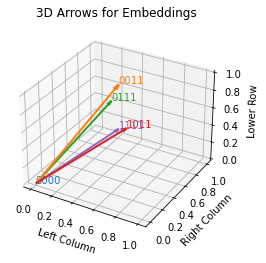

In [36]:
# Extract the corresponding patches for the input indices
patch_texts = ["".join(map(str, patch.tolist())) for patch in patches[input]]

# Set up the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the arrows
origin = torch.zeros(3)  # All arrows start from the origin
for i, (embedding, text) in enumerate(zip(embeddings, patch_texts)):
    ax.quiver(
        origin[0], origin[1], origin[2],  # Starting point (0, 0, 0)
        embedding[0].item(), embedding[1].item(), embedding[2].item(),  # Arrow vector
        color=f'C{i}', linewidth=2, arrow_length_ratio=0.05  # Smaller arrowhead
    )
    # Add text at the end of the arrow
    ax.text(
        embedding[0].item(), embedding[1].item(), embedding[2].item(),  # Text position
        text,
        fontsize=10,
        color=f'C{i}'
    )

# Set labels
ax.set_xlabel("Left Column")
ax.set_ylabel("Right Column")
ax.set_zlabel("Lower Row")
ax.set_title("3D Arrows for Embeddings")

# Show the plot
plt.show()

# Training script

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Define the dataset
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        """
        Args:
            images (Tensor): Tensor of shape (num_images, 64, 64) with binary values (0 or 1).
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (64, 64)
        return torch.tensor(image, dtype=torch.float32)

# Example dataset (random binary images)
num_images = 100
images = (torch.rand(num_images, 64, 64) > 0.5).float()
dataset = BinaryImageDataset(images)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define the Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.embed_dim = embed_dim

        # Predefined embedding matrix (fixed weights)
        self.embedding_matrix = nn.Embedding(num_tokens + 1, embed_dim)  # +1 for the masked patch token
        self.embedding_matrix.weight.requires_grad = False  # Fixed weights

        # Transformer encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

        # Output prediction layer
        self.fc_out = nn.Linear(embed_dim, num_tokens)

    def forward(self, patches, mask):
        """
        Args:
            patches (Tensor): Input patches indices (flattened 2x2 patches), shape (batch_size, num_patches).
            mask (Tensor): Mask tensor (1 for masked, 0 for visible), shape (batch_size, num_patches).
        
        Returns:
            logits: Predictions for the masked patches, shape (batch_size, num_patches, num_tokens).
        """
        # Embed the patches (apply mask token where necessary)
        embeddings = self.embedding_matrix(patches)
        embeddings[mask == 1] = self.embedding_matrix.weight[-1]  # Use the mask token embedding

        # Pass through Transformer layers
        x = embeddings.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embed_dim)
        for layer in self.layers:
            x = layer(x)
        x = x.permute(1, 0, 2)  # Back to (batch_size, seq_len, embed_dim)

        # Output logits for all patches
        logits = self.fc_out(x)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, feedforward_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        feedforward_output = self.feedforward(x)
        x = self.norm2(x + feedforward_output)
        return x

# Define utility functions
def preprocess_image(image):
    """
    Splits a binary 64x64 image into flattened 2x2 patches.
    Returns patch indices tensor (num_patches, 4).
    """
    patches = image.unfold(0, 2, 2).unfold(1, 2, 2)
    patches = patches.contiguous().view(-1, 4)  # (num_patches, 4)
    patch_indices = (patches * torch.tensor([8, 4, 2, 1])).sum(dim=1)  # Convert binary patch to index
    return patch_indices

def mask_patches(patches, mask_ratio=0.8):
    """
    Masks a fraction of the patches.
    Returns the masked patches and mask tensor.
    """
    num_patches = patches.shape[0]
    mask = torch.rand(num_patches) < mask_ratio
    masked_patches = patches.clone()
    masked_patches[mask] = num_tokens  # Masked patches use the special token index
    return masked_patches, mask

# Training loop
embed_dim = 4 # Embedding dimension
num_heads = 2 # Number of attention heads
feedforward_dim = 8 # Feedforward layer dimension 
num_layers = 2 # Number of transformer layers
num_tokens = 16  # 2^(2x2)
max_patches = 32 * 32 # 64x64 image with 2x2 patches
dropout = 0.0 # Dropout rate
learning_rate = 1e-4
num_epochs = 10

model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize W&B
wandb.init(
    project="vision-transformer",
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "batch_size": len(dataloader),
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
    }
)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images in dataloader:
        # Move data to GPU
        images = images.to(device)
        
        # Preprocess and mask patches
        patch_indices = torch.cat([preprocess_image(img) for img in images])  # (batch_size * num_patches)
        patch_indices = patch_indices.to(device)
        masked_patches, mask = mask_patches(patch_indices)
        masked_patches, mask = masked_patches.to(device), mask.to(device)
        
        # Forward pass
        logits = model(masked_patches, mask)
        loss = criterion(logits.view(-1, num_tokens), patch_indices.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Log metrics to W&B
    avg_loss = total_loss / len(dataloader)
    wandb.log({"epoch": epoch + 1, "epoch_loss": avg_loss})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

# Save the model and upload it to W&B
torch.save(model.state_dict(), "model.pth")
wandb.save("model.pth")